In [182]:
#####################
# Dependency import #
#####################

import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import json

In [183]:
###################
# Dataset loading #
###################

# Dataset: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities?resource=download
dt = pd.read_csv('city_temperature.csv')
dt.head(100)

C:\Users\teodo\AppData\Local\Temp\ipykernel_8924\1848890338.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv('city_temperature.csv')


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
95,Africa,Algeria,NaN,Algiers,4,6,1995,59.0
96,Africa,Algeria,NaN,Algiers,4,7,1995,54.9
97,Africa,Algeria,NaN,Algiers,4,8,1995,54.2
98,Africa,Algeria,NaN,Algiers,4,9,1995,57.8


In [184]:
#################
# Data cleaning #
#################

dt.drop(columns=["State", "Region"], axis=1, inplace=True)
dt.drop(index=dt.loc[dt["Day"] <= 0].index, inplace=True)
dt.drop(index=dt.loc[dt["AvgTemperature"] <= -20].index, inplace=True)
dt.dropna()

dt

,Country,City,Month,Day,Year,AvgTemperature
0,Algeria,Algiers,1,1,1995,64.2
1,Algeria,Algiers,1,2,1995,49.4
2,Algeria,Algiers,1,3,1995,48.8
3,Algeria,Algiers,1,4,1995,46.4
4,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...
2906322,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,US,San Juan Puerto Rico,7,30,2013,83.8


In [185]:
############################################
# MSE and R2 progression datasets assembly #
############################################

index = 0
g_mse_comp = {"Training MSE" : [], "Test MSE": []}
g_mse_comp_indexes = []
g_r2_progression = {"Polynomial degree" : [], "R2": []}
g_mse_progression = {"Polynomial degree" : [], "MSE": []}
g_model = None


l_mse_comp = {"Training MSE" : [], "Test MSE": []}
l_mse_comp_indexes = []
l_r2_progression = {"Polynomial degree" : [], "R2": []}
l_mse_progression = {"Polynomial degree" : [], "MSE": []}
l_model = None


def addMetrics(t_mse, c_mse, r2, i, mse_comp, mse_comp_indexes, r2_progression, mse_progression):
    print("\n\n")
    print("Polynomial degree:", i)
    print("Training MSE:", t_mse)
    print("MSE:", c_mse)
    print("R2:", r2)
    print(l_mse_comp)
    
    mse_comp["Training MSE"].append(t_mse)
    mse_comp["Test MSE"].append(c_mse)
    mse_comp_indexes.append(len(mse_comp["Test MSE"]))
    
    r2_progression["Polynomial degree"].append(i)
    r2_progression["R2"].append(r2)
    
    mse_progression["Polynomial degree"].append(i)
    mse_progression["MSE"].append(c_mse)


<Axes: xlabel='Year', ylabel='AvgTemperature'>

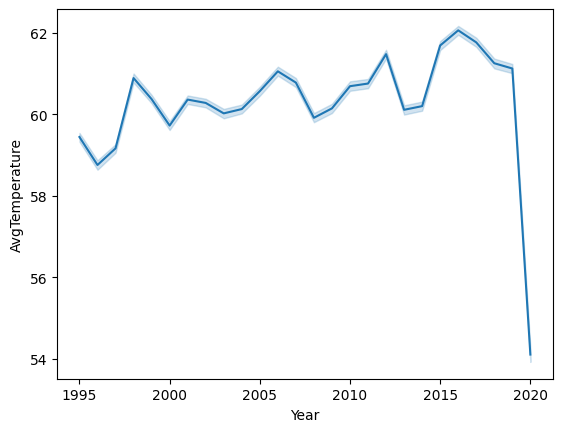

In [186]:
#######################################
# Visualisation of global temperature #
#######################################
sb.lineplot(data=dt, x="Year", y="AvgTemperature")

In [187]:

global g_mse_comp
global g_mse_comp_indexes
global g_r2_progression
global g_mse_progression
global index
global g_model
index = 1

tmp = dt.groupby(by=["Day", "Month", "Year"])["AvgTemperature"].mean().reset_index()

mse = None
r2 = None

degree = 1


for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=tmp[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, tmp["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test)
    
    t_predictions = poly_regression.predict(x_train)
    
    t_mse = metrics.mean_squared_error(y_pred=t_predictions, y_true=y_train)
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)
    
    addMetrics(t_mse, c_mse, r2, i, g_mse_comp, g_mse_comp_indexes, g_r2_progression, g_mse_progression)
    
    # If the MSE calculated on the training data is smaller 
    # than the one calculated on the testing data is smaller
    # then the model is overfitted and the operation stops     
    if mse is not None and r2 is not None:
        if c_mse > t_mse:
            if c_mse <= mse or c_r2 >= r2:
                g_model = _model
            else:
                break
        else:
            break
    degree = i
    mse = c_mse
    r2 = c_r2
    print(g_model)
        
        
g_model = {"x_intercept": g_model.intercept_, "Beta_Coefficients":  g_model.coef_.tolist(), "polynomial_degree": degree}
model_file = open(file="global_temp_model.json", mode="w")
jf = json.dump(obj=g_model,fp= model_file, indent=4)
model_file.flush()
model_file.close()
del(model_file)


g_comp = pd.DataFrame(data=g_mse_comp, index=g_mse_comp_indexes)
g_r2_prog = pd.DataFrame(data=g_r2_progression, index=g_mse_comp_indexes)
g_mse_prog = pd.DataFrame(data=g_mse_progression, index=g_mse_comp_indexes)

g_comp




Polynomial degree: 1
Training MSE: 122.47184489209222
MSE: 120.45976088199465
R2: None
{'Training MSE': [], 'Test MSE': []}
None



Polynomial degree: 2
Training MSE: 16.819758966472754
MSE: 16.854039219513282
R2: 0.06813297308549271
{'Training MSE': [], 'Test MSE': []}
LinearRegression()



Polynomial degree: 3
Training MSE: 11.591553246037511
MSE: 11.610032760393254
R2: 0.8648740776388233
{'Training MSE': [], 'Test MSE': []}
LinearRegression()



Polynomial degree: 4
Training MSE: 6.128660873668858
MSE: 5.863357951888912
R2: 0.9086973708473617
{'Training MSE': [], 'Test MSE': []}


,Training MSE,Test MSE
1,122.471845,120.459761
2,16.819759,16.854039
3,11.591553,11.610033
4,6.128661,5.863358


(0.0, 126.18958102849994)

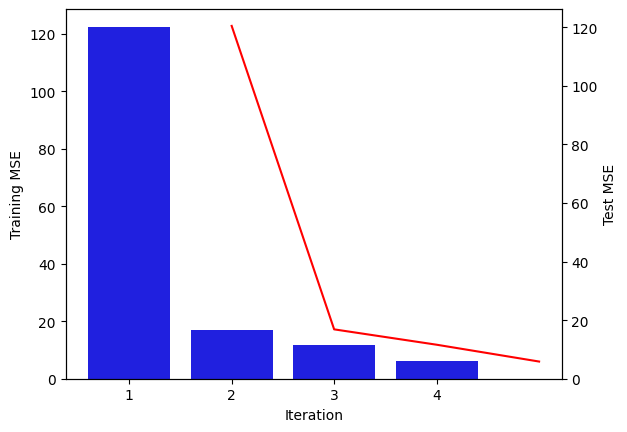

In [188]:
##########################################################################################
# Comparison of the MSE in predicting training data VS testing data for the Global model #
##########################################################################################
p1 = sb.barplot(data=g_comp, x=g_comp.index, y="Training MSE", color="b")
p1.set_xlabel("Iteration")
p1.set_ylim(bottom=0)
plt.twinx()
p2 = sb.lineplot(data=g_comp, x=g_comp.index, y="Test MSE",color="r")
p2.set_xlabel("Iteration")
p2.set_ylim(bottom=0)

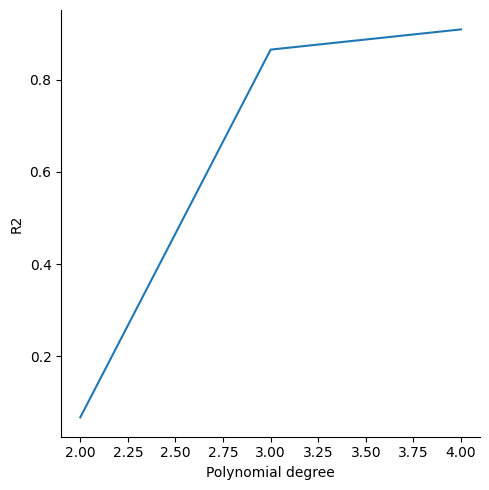

In [189]:
#########################################################################################################
# Visualisation of the R2 score progression in relation with the polynomial degree for the Global model #
#########################################################################################################

sb.relplot(data= g_r2_prog, x="Polynomial degree", y="R2", kind="line")

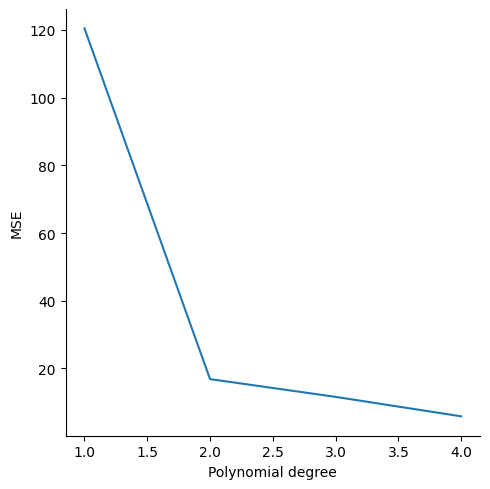

In [190]:
##########################################################################################################
# Visualisation of the MSE score progression in relation with the polynomial degree for the Global model #
##########################################################################################################

sb.relplot(data= g_mse_prog, x="Polynomial degree", y="MSE", kind="line")

<Axes: xlabel='Year', ylabel='AvgTemperature'>

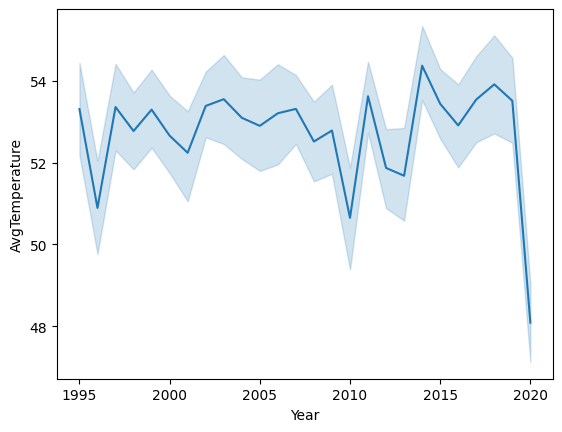

In [191]:
#########################################
# Visualisation of London's temperature #
#########################################

dtl =  dt[(dt['Country'] == 'United Kingdom') & (dt['City'] == 'London')]
sb.lineplot(data=dtl, x="Year", y="AvgTemperature")

In [192]:

global l_mse_comp
global l_mse_comp_indexes 
global l_r2_progression
global l_mse_progression
global index
global l_model
index = 1

mse = None
r2 = None

degree = 1
model = None

london_temp_model = None


for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=dtl[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, dtl["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test)
    
    t_predictions = poly_regression.predict(x_train)
    
    t_mse = metrics.mean_squared_error(y_pred=t_predictions, y_true=y_train)
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)

    addMetrics(t_mse, c_mse, r2, i, l_mse_comp, l_mse_comp_indexes, l_r2_progression, l_mse_progression)
    
    # If the MSE calculated on the training data is smaller 
    # than the one calculated on the testing data is smaller
    # then the model is overfitted and the operation stops     
    if mse is not None and r2 is not None:
        if c_mse > t_mse:
            if c_mse <= mse or c_r2 >= r2:
                l_model = _model
            else:
                break
        else:
            break
    degree = i
    mse = c_mse
    r2 = c_r2
        
        
l_model = {"x_intercept": l_model.intercept_, "Beta_Coefficients":  l_model.coef_.tolist(), "polynomial_degree": degree}
model_file = open(file="london_temp_model.json", mode="w")
jf = json.dump(obj=l_model,fp= model_file, indent=4)
model_file.flush()
model_file.close()
del(model_file)


l_comp = pd.DataFrame(data=l_mse_comp, index=l_mse_comp_indexes)
l_r2_prog = pd.DataFrame(data=l_r2_progression, index=l_mse_comp_indexes)
l_mse_prog = pd.DataFrame(data=l_mse_progression, index=l_mse_comp_indexes)

l_comp




Polynomial degree: 1
Training MSE: 94.44159285214165
MSE: 94.85998545965425
R2: None
{'Training MSE': [], 'Test MSE': []}



Polynomial degree: 2
Training MSE: 38.29644164557405
MSE: 39.44370379329228
R2: 0.04577565894403357
{'Training MSE': [94.44159285214165], 'Test MSE': [94.85998545965425]}



Polynomial degree: 3
Training MSE: 32.1251760135247
MSE: 32.74028635877432
R2: 0.6080778315370181
{'Training MSE': [94.44159285214165, 38.29644164557405], 'Test MSE': [94.85998545965425, 39.44370379329228]}



Polynomial degree: 4
Training MSE: 26.93850532669216
MSE: 27.363428171733204
R2: 0.6712248181928846
{'Training MSE': [94.44159285214165, 38.29644164557405, 32.1251760135247], 'Test MSE': [94.85998545965425, 39.44370379329228, 32.74028635877432]}



Polynomial degree: 5
Training MSE: 26.75592624608372
MSE: 27.814561134060764
R2: 0.7246941634709396
{'Training MSE': [94.44159285214165, 38.29644164557405, 32.1251760135247, 26.93850532669216], 'Test MSE': [94.85998545965425, 39.4437037932

,Training MSE,Test MSE
1,94.441593,94.859985
2,38.296442,39.443704
3,32.125176,32.740286
4,26.938505,27.363428
5,26.755926,27.814561
6,27.029348,27.191017
7,26.991399,27.315139


(0.0, 98.24343389322914)

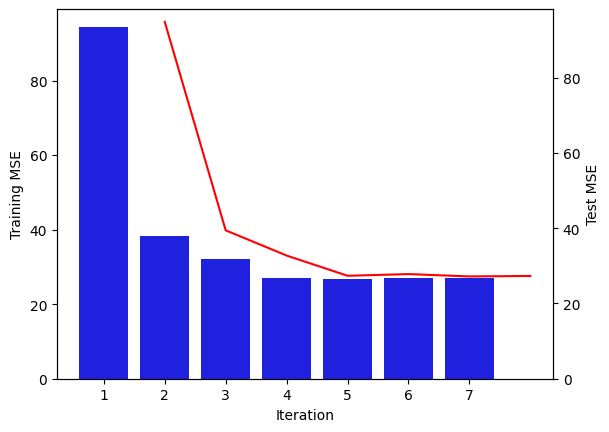

In [193]:
##########################################################################################
# Comparison of the MSE in predicting training data VS testing data for the Global model #
##########################################################################################
p1 = sb.barplot(data=l_comp, x=l_comp.index, y="Training MSE", color="b")
p1.set_xlabel("Iteration")
p1.set_ylim(bottom=0)
plt.twinx()
p2 = sb.lineplot(data=l_comp, x=l_comp.index, y="Test MSE",color="r")
p2.set_xlabel("Iteration")
p2.set_ylim(bottom=0)

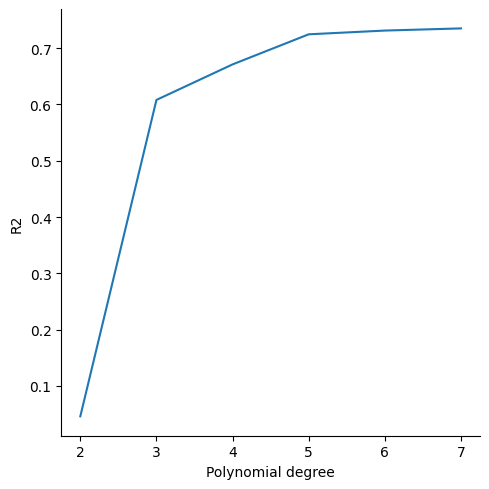

In [194]:
#########################################################################################################
# Visualisation of the R2 score progression in relation with the polynomial degree for the Global model #
#########################################################################################################

sb.relplot(data= l_r2_prog, x="Polynomial degree", y="R2", kind="line")

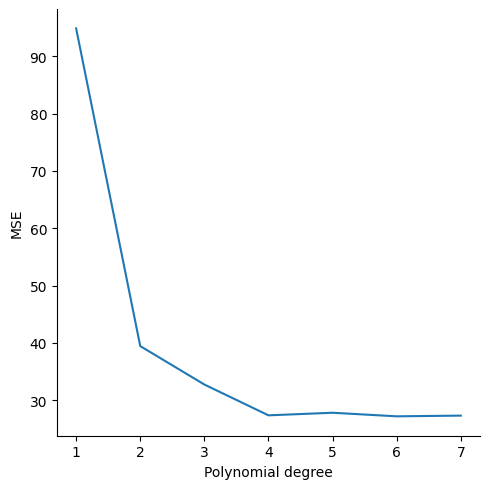

In [195]:
##########################################################################################################
# Visualisation of the MSE score progression in relation with the polynomial degree for the Global model #
##########################################################################################################

sb.relplot(data= l_mse_prog, x="Polynomial degree", y="MSE", kind="line")